# Rectangle selection

In this example, we will use a custom drawing tool to draw rectangles on a 2D figure.
The data inside the rectangles will be summed along the vertical dimension,
and displayed on a one-dimensional plot below the image.

In [1]:
%matplotlib widget
import plopp as pp
import scipp as sc

We first generate some data that contains three bands of peaks that all have different spreads.

In [2]:
from plopp.data.examples import three_bands

da = three_bands()

We then construct our custom tool,
using Mpltoolbox's [Rectangles tool](https://mpltoolbox.readthedocs.io/en/latest/rectangles.html),
and inheriting from Plopp's
[DrawingTool](https://scipp.github.io/plopp/about/generated/plopp.widgets.drawing.DrawingTool.html).

In [3]:
from plopp.widgets.drawing import DrawingTool
from functools import partial
from mpltoolbox import Rectangles


def vertical_sum(da, rect_info):
    """
    Function that slices the data according to the
    rectangle size/position, and sums along the
    vertical dimension.
    """
    x = rect_info['x']
    y = rect_info['y']
    b = min(y['bottom'], y['top'])
    t = max(y['bottom'], y['top'])
    l = min(x['left'], x['right'])
    r = max(x['left'], x['right'])
    return da[y['dim'], b:t][x['dim'], l:r].sum(y['dim'])


def _get_rect_info(artist, figure):
    """
    Convert the raw rectangle info to a dict containing the dimensions of
    each axis, and values with units.
    """
    return lambda: {
        'x': {
            'dim': figure.canvas.dims['x'],
            'left': sc.scalar(artist.xy[0], unit=figure.canvas.units['x']),
            'right': sc.scalar(
                artist.xy[0] + artist.width, unit=figure.canvas.units['x']
            ),
        },
        'y': {
            'dim': figure.canvas.dims['y'],
            'bottom': sc.scalar(artist.xy[1], unit=figure.canvas.units['y']),
            'top': sc.scalar(
                artist.xy[1] + artist.height, unit=figure.canvas.units['y']
            ),
        },
    }


RectangleTool = partial(
    DrawingTool, tool=Rectangles, get_artist_info=_get_rect_info, icon='vector-square'
)

Finally, we create our visualization interface with two figures,
adding our new tool to the toolbar.

In [4]:
from plopp.widgets import Box

data_node = pp.Node(da)

f2d = pp.imagefigure(data_node, norm='log')
f1d = pp.linefigure()

r = RectangleTool(figure=f2d, input_node=data_node, func=vertical_sum, destination=f1d)
f2d.toolbar['roi'] = r

box = Box([f2d, f1d])

In [5]:
r.value = True
r._tool.click(50, 200)
r._tool.click(200, 250)
r._tool.click(30, 50)
r._tool.click(250, 170)

In [6]:
box

Box(children=(InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(i…

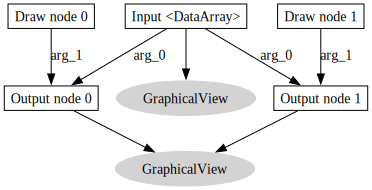

In [7]:
pp.show_graph(data_node)

In [8]:
# This cell is used to generate the thumbnail for the docs gallery.
# It is hidden from the online documentation.
f2d.save('../_static/gallery/rectangle-selection-thumbnail.png')

## Advanced Feature - Merge All Drawings

There is an extra node that contains all drawings as a dictionary <br>
so that you can attach another node that uses all drawings at once.

As an example, let's add another node that vertically sum all selected region <br>
using `vertical_sum_all` in the following cell.

In [18]:
def vertical_sum_all(da, rect_infos: dict):
    """
    Function that slices the data according to the
    rectangle size/position, and sums along the
    vertical dimension.
    """
    from functools import reduce
    if len(rect_infos) > 0:
        masks = [
            (da.coords['x'] > max(rect_info['x']['left'], rect_info['x']['right']))
            | (da.coords['x'] < min(rect_info['x']['left'], rect_info['x']['right']))
            | (da.coords['y'] > max(rect_info['y']['bottom'], rect_info['y']['top']))
            | (da.coords['y'] < min(rect_info['y']['bottom'], rect_info['y']['top']))
            for rect_info in rect_infos.values()
        ]
        mask = reduce(lambda x, y: x & y, masks)
        selected_sample_region = da.copy(deep=False)
        selected_sample_region.masks['roi'] = mask['x', :-1]['y', :-1]
        return selected_sample_region.sum(da.dims[-1])
    else:
        return da.sum(da.dims[-1])

In [14]:
from plopp.widgets import Box

data_node = pp.Node(da)

f2d = pp.imagefigure(data_node, norm='log')
f1d = pp.linefigure(title="Vertical sum of individual selected regions")

r = RectangleTool(figure=f2d, input_node=data_node, func=vertical_sum, destination=f1d)
# Attach another node to the all-drawings-node.
merge_sum = pp.Node(vertical_sum_all)
merge_sum.add_parents(data_node, r.all_drawings_node)
f1d_merged = pp.linefigure(merge_sum, title='Vertical sum of all selected regions', grid=True)

f2d.toolbar['roi'] = r

box = Box([f2d, f1d, f1d_merged])

In [15]:
r.value = True
r._tool.click(50, 200)
r._tool.click(200, 250)
r._tool.click(30, 50)
r._tool.click(250, 170)

In [16]:
box

Box(children=(InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(i…

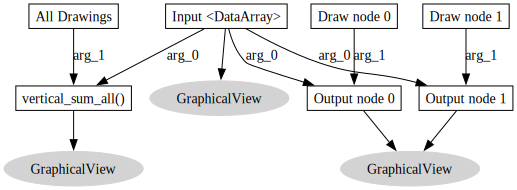

In [17]:
pp.show_graph(data_node)